(161666, 784)


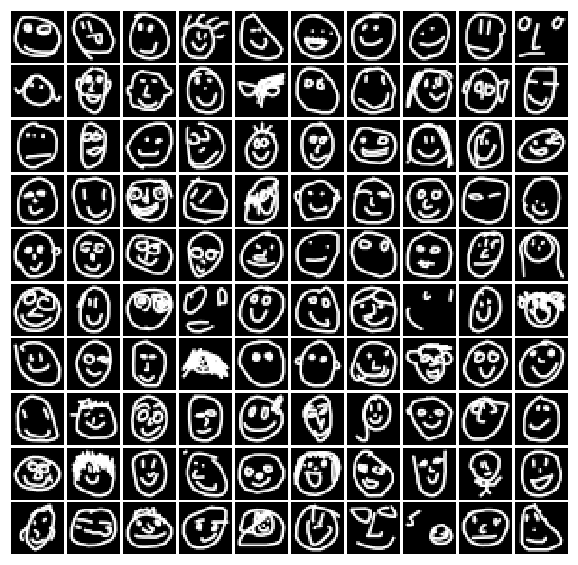

255


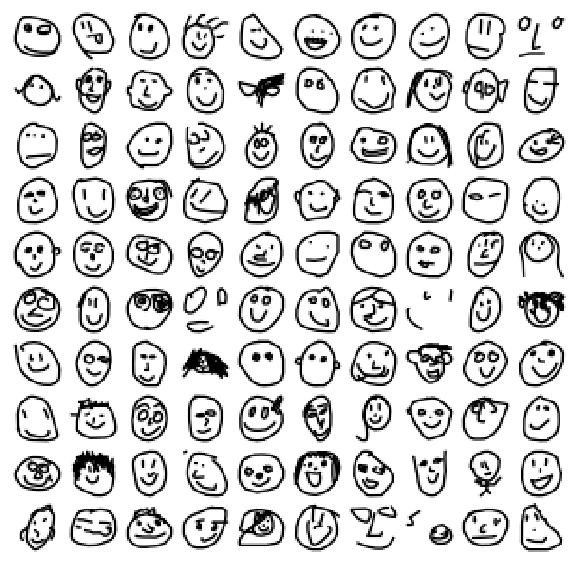

In [1]:
#
# COMMENTS TO DO
#
#Condensed code based on the code from: https://jmetzen.github.io/2015-11-27/vae.html

%matplotlib inline
import tensorflow as tf
import tensorflow.contrib.layers as layers
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import os
import time
import glob

def plot(samples, w, h, fw, fh, iw=28, ih=28):
    fig = plt.figure(figsize=(fw, fh))
    gs = gridspec.GridSpec(w, h)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(iw, ih), cmap='Greys_r')

    return fig


def encoder(images, num_outputs_h0=8, num_outputs_h1=16, kernel_size=5, stride=2, num_hidden_fc=1024, z_dim=100):
        
    print("Encoder")

    h0 = layers.convolution2d(
        inputs=images,
        num_outputs=num_outputs_h0,
        kernel_size=kernel_size,
        stride=stride,
        activation_fn=tf.nn.relu,
        scope='e_cnn_%d' % (0,)
    )
    
    print("Convolution 1 -> {}".format(h0))

    h1 = layers.convolution2d(
        inputs=h0,
        num_outputs=num_outputs_h1,
        kernel_size=kernel_size,
        stride=stride,
        activation_fn=tf.nn.relu,
        scope='e_cnn_%d' % (1,)
    )
    
    print("Convolution 2 -> {}".format(h1))

    h1_dim = h1.get_shape().as_list()[1]

    h2_flat = tf.reshape(h1, [-1, h1_dim * h1_dim * num_outputs_h1])

    print("Reshape  -> {}".format(h2_flat))
    
    h2_flat =layers.fully_connected(
        inputs=h2_flat,
        num_outputs=num_hidden_fc,
        activation_fn=tf.nn.relu,
        scope='e_d_%d' % (0,)
    )
    
    print("FC 1  -> {}".format(h2_flat))

    z_mean =layers.fully_connected(
        inputs=h2_flat,
        num_outputs=z_dim,
        activation_fn=None,
        scope='e_d_%d' % (1,)
    )
    
    print("Z mean -> {}".format(z_mean))

    z_log_sigma_sq =layers.fully_connected(
        inputs=h2_flat,
        num_outputs=z_dim,
        activation_fn=None,
        scope='e_d_%d' % (2,)
    )

    return z_mean, z_log_sigma_sq 



def decoder(z, num_hidden_fc=1024, h1_reshape_dim=7, kernel_size=5, h1_channels=16, h2_channels = 8, output_channels=1, strides=2, output_dims=784):
    
    print("Decoder")
    
    batch_size = tf.shape(z)[0]  
    
    h0 =layers.fully_connected(
        inputs=z,
        num_outputs=num_hidden_fc,
        activation_fn=tf.nn.relu,
        scope='d_d_%d' % (0,)
    )
    
    print("FC 1  -> {}".format(h0))

    h1 =layers.fully_connected(
        inputs=h0,
        num_outputs=h1_reshape_dim*h1_reshape_dim*h1_channels,
        activation_fn=tf.nn.relu,
        scope='d_d_%d' % (1,)
    )
    
    print("FC 2  -> {}".format(h1))

    h1_reshape = tf.reshape(h1, [-1, h1_reshape_dim, h1_reshape_dim, h1_channels])

    print("Reshape  -> {}".format(h1_reshape))

    wdd2 = tf.get_variable('wd2', shape=(kernel_size, kernel_size, h2_channels, h1_channels), initializer=tf.contrib.layers.xavier_initializer())
    bdd2 = tf.get_variable('bd2', shape=(h2_channels,), initializer=tf.constant_initializer(0))
    
    h2 = tf.nn.conv2d_transpose(h1_reshape, wdd2, output_shape=(batch_size, h1_reshape_dim*2,  h1_reshape_dim*2, h2_channels), strides=(1, strides, strides, 1), padding='SAME')

    h2_out = tf.nn.relu(h2 + bdd2)
    
    h2_out = tf.reshape(h2_out, (batch_size, h1_reshape_dim*2,  h1_reshape_dim*2, h2_channels))
    
    print("DeConv 1  -> {}".format(h2_out))
    
    h2_dim = h2_out.get_shape().as_list()[1]

    wdd3 = tf.get_variable('wd3', shape=(kernel_size, kernel_size, output_channels, h2_channels), initializer=tf.contrib.layers.xavier_initializer())
    bdd3 = tf.get_variable('bd3', shape=(output_channels,), initializer=tf.constant_initializer(0))
 
    h3 = tf.nn.conv2d_transpose(h2_out, wdd3, output_shape=(batch_size, h2_dim*2, h2_dim*2, output_channels), strides=(1, strides, strides, 1), padding='SAME')

    h3_out = tf.nn.sigmoid(h3 + bdd3)
    
    #Workaround to use dinamyc batch size...
    h3_out = tf.reshape(h3_out, (batch_size, h2_dim*2, h2_dim*2, output_channels))

    print("DeConv 2  -> {}".format(h3_out))

    h3_reshape = tf.reshape(h3_out, [-1, output_dims])
    
    print("Reshape  -> {}".format(h3_reshape))

    return h3_reshape
    
    
faces_dataset = np.load("full_numpy_bitmap_face.npy")

print(faces_dataset.shape)

fig=plot(faces_dataset[:100], 10, 10, 10, 10)
plt.show()

print(np.max(faces_dataset))

faces_dataset = faces_dataset / 255.0

faces_dataset = np.abs(faces_dataset - 1)


fig=plot(faces_dataset[:100], 10, 10, 10, 10)
plt.show()

In [2]:
#For reconstructing the same or a different image (denoising)
images = tf.placeholder(tf.float32, shape=(None, 784))

images_28x28x1 = tf.reshape(images, [-1, 28, 28, 1])

images_target = tf.placeholder(tf.float32, shape=(None, 784))

is_training_placeholder = tf.placeholder(tf.bool)
learning_rate_placeholder = tf.placeholder(tf.float32)

z_dim = 100

with tf.variable_scope("encoder") as scope:

    z_mean, z_log_sigma_sq = encoder(images_28x28x1)
    

with tf.variable_scope("reparameterization") as scope:
    
    eps = tf.random_normal(shape=tf.shape(z_mean), mean=0.0, stddev=1.0, dtype=tf.float32)

    # z = mu + sigma*epsilon
    z = tf.add(z_mean, tf.multiply(tf.sqrt(tf.exp(z_log_sigma_sq)), eps))
    

with tf.variable_scope("decoder") as scope:
        
    x_reconstr_mean = decoder(z)
    
    scope.reuse_variables()

    ##### SAMPLING #######
    
    z_input = tf.placeholder(tf.float32, shape=[None, z_dim])

    x_sample = decoder(z_input)


#reconstr_loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=x_reconstr_mean, labels=images_target), reduction_indices=1)

offset=1e-7
obs_ = tf.clip_by_value(x_reconstr_mean, offset, 1 - offset)

reconstr_loss = -tf.reduce_sum(images_target * tf.log(obs_) + (1-images_target) * tf.log(1 - obs_), 1)

latent_loss = -.5 * tf.reduce_sum(1. + z_log_sigma_sq - tf.pow(z_mean, 2) - tf.exp(z_log_sigma_sq), reduction_indices=1)

cost = tf.reduce_mean(reconstr_loss + latent_loss)

optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate_placeholder).minimize(cost)

Encoder
Convolution 1 -> Tensor("encoder/e_cnn_0/Relu:0", shape=(?, 14, 14, 8), dtype=float32)
Convolution 2 -> Tensor("encoder/e_cnn_1/Relu:0", shape=(?, 7, 7, 16), dtype=float32)
Reshape  -> Tensor("encoder/Reshape:0", shape=(?, 784), dtype=float32)
FC 1  -> Tensor("encoder/e_d_0/Relu:0", shape=(?, 1024), dtype=float32)
Z mean -> Tensor("encoder/e_d_1/BiasAdd:0", shape=(?, 100), dtype=float32)
Decoder
FC 1  -> Tensor("decoder/d_d_0/Relu:0", shape=(?, 1024), dtype=float32)
FC 2  -> Tensor("decoder/d_d_1/Relu:0", shape=(?, 784), dtype=float32)
Reshape  -> Tensor("decoder/Reshape:0", shape=(?, 7, 7, 16), dtype=float32)
DeConv 1  -> Tensor("decoder/Reshape_1:0", shape=(?, 14, 14, 8), dtype=float32)
DeConv 2  -> Tensor("decoder/Reshape_2:0", shape=(?, 28, 28, 1), dtype=float32)
Reshape  -> Tensor("decoder/Reshape_3:0", shape=(?, 784), dtype=float32)
Decoder
FC 1  -> Tensor("decoder/d_d_0_1/Relu:0", shape=(?, 1024), dtype=float32)
FC 2  -> Tensor("decoder/d_d_1_1/Relu:0", shape=(?, 784), d

In [4]:
init = tf.global_variables_initializer()

epochs = 2000
batch_size = 100

n_batches = faces_dataset.shape[0]//batch_size

learning_rate=0.001

OUTPUT_PATH = "OUT_CVAE_FACES/"
MODELS_PATH = "MODELS_CVAE_FACES/"

if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)
    
if not os.path.exists(MODELS_PATH):
    os.makedirs(MODELS_PATH)

CVAE_SAVER = tf.train.Saver()

print("N. Batches: {}".format(n_batches))

# Launch the graph
with tf.Session() as sess:
    
    sess.run(init)
    
    for epoch in range(epochs):
        
        start_time = time.time()
        
        mean_loss = 0

        for n_batch in range(n_batches):
            
            batch_xs = faces_dataset[n_batch * batch_size:(n_batch+1) * batch_size]
            
            out_recon, out_latent_loss, out_cost, _ = sess.run([
                x_reconstr_mean, latent_loss, cost, optimizer], 
                           feed_dict={
                               images: batch_xs, 
                               images_target: batch_xs, 
                               is_training_placeholder: True,
                               learning_rate_placeholder: learning_rate})


            mean_loss += out_cost
            #print(" Loss {}".format(out_cost))
        
           
        if epoch % 100 == 0:
            
            print("Epoch {}, Mean Loss {:.2f}, time: {}".format(epoch, mean_loss/n_batches, time.time() - start_time))
            
            fig=plot(batch_xs, 10, 10, 10, 10)
            #plt.show()
            plt.savefig(OUTPUT_PATH + 'target_{}.png'.format(str(epoch).zfill(3)), bbox_inches='tight')
            plt.close(fig)

            fig=plot(out_recon, 10, 10, 10, 10)
            #plt.show()
            plt.savefig(OUTPUT_PATH + 'output_{}.png'.format(str(epoch).zfill(3)), bbox_inches='tight')
            plt.close(fig)

            

    # Save model weights to disk
    save_path = CVAE_SAVER.save(sess, MODELS_PATH + 'CONV_VAE_FACES.ckpt')
    print("Model saved in file: {}".format(save_path))

N. Batches: 1616
Epoch 0, Mean Loss 280.27, time: 6.424053192138672
Epoch 100, Mean Loss 212.16, time: 6.074331283569336
Epoch 200, Mean Loss 210.81, time: 6.001091718673706
Epoch 300, Mean Loss 210.25, time: 6.084536552429199
Epoch 400, Mean Loss 209.89, time: 5.987345218658447
Epoch 500, Mean Loss 209.61, time: 5.986549139022827
Epoch 600, Mean Loss 209.46, time: 5.9982099533081055
Epoch 700, Mean Loss 209.33, time: 5.9539570808410645
Epoch 800, Mean Loss 209.22, time: 5.96922755241394
Epoch 900, Mean Loss 209.14, time: 5.969529867172241
Epoch 1000, Mean Loss 209.07, time: 5.9456627368927
Epoch 1100, Mean Loss 208.97, time: 5.909327030181885
Epoch 1200, Mean Loss 208.92, time: 5.939067363739014
Epoch 1300, Mean Loss 209.07, time: 5.969032287597656
Epoch 1400, Mean Loss 208.83, time: 5.959395885467529
Epoch 1500, Mean Loss 208.78, time: 6.0258073806762695
Epoch 1600, Mean Loss 209.25, time: 5.950651407241821
Epoch 1700, Mean Loss 209.32, time: 5.935228109359741
Epoch 1800, Mean Loss 2

Model restored in file: MODELS_CVAE_FACES/CONV_VAE_FACES.ckpt


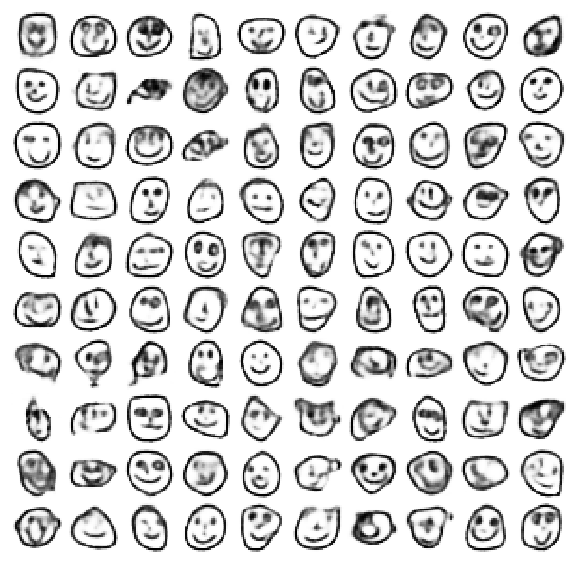

In [20]:
with tf.Session() as sess:
    
    sess.run(init)

    CVAE_SAVER.restore(sess, save_path)
    print("Model restored in file: {}".format(save_path))
    
    random_gen = sess.run(x_sample,feed_dict={z_input: np.random.randn(100, z_dim)})
    
    #random_gen[ random_gen < 0.6] = 0
    
    fig=plot(random_gen, 10, 10, 10, 10)
    plt.show()

    
                            

Model restored in file: MODELS_CVAE_FACES/CONV_VAE_FACES.ckpt


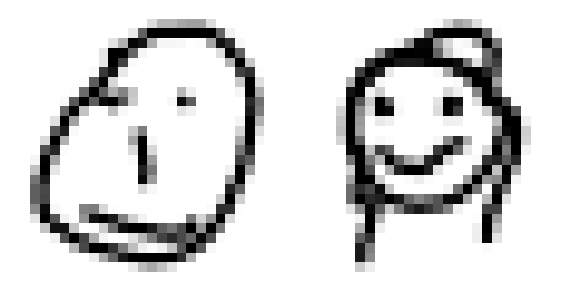

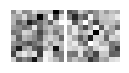

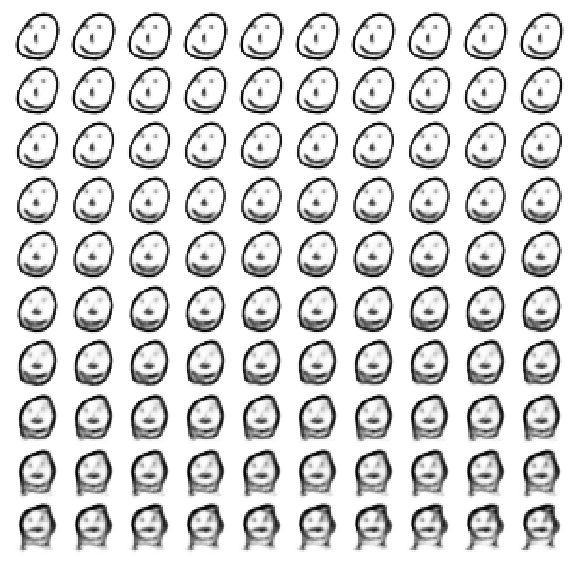

In [22]:
with tf.Session() as sess:
    
    sess.run(init)

    CVAE_SAVER.restore(sess, save_path)
    print("Model restored in file: {}".format(save_path))
    
    INTERPOLATION_STEPS = 100
    alphaValues = np.linspace(0, 1, INTERPOLATION_STEPS)
    
    random_indexes = np.random.permutation(faces_dataset.shape[0])[:2]
    
    x_samples = faces_dataset[random_indexes].copy()
    
    z_projected_samples = sess.run(z, feed_dict={images: x_samples})
    
    fig=plot(x_samples, 1, 2, 10, 10)
    plt.show()
    
    fig=plot(z_projected_samples, 10, 10, 10, 10, 10, 10)
    plt.show()
    
    z_samples_interpolated = np.zeros((INTERPOLATION_STEPS, z_dim))
    
    for i, alpha in enumerate(alphaValues):
        z_samples_interpolated[i] = z_projected_samples[0]*(1-alpha) + z_projected_samples[1]*alpha
        
    
    x_interpolated = sess.run(x_sample, feed_dict={z_input: z_samples_interpolated})
    
    #x_interpolated[ x_interpolated < 0.6] = 0
    
    fig=plot(x_interpolated, 10, 10, 10, 10)
    plt.show()
    
    
    